In [ ]:
%tensorflow_version 2.x
!pip install tensorflow-gpu

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import scipy.misc

import cv2
from imutils import paths
from tqdm import tqdm
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
import os
import tensorflow as tf
import datetime
from glob import glob
import IPython.display as display
from IPython.display import clear_output
import math
import time
from tensorflow.keras.layers import *
import warnings
warnings.filterwarnings('ignore')
AUTOTUNE = tf.data.experimental.AUTOTUNE
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import csv
print(f'Tensorflow ver. {tf.__version__}')

Tensorflow ver. 2.4.1


In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
my_drive = GoogleDrive(gauth)

def delTrash() :
    for file in my_drive.ListFile({'q': "trashed = true"}).GetList():
        #print(f'the file "{a_file['title']}", is about to get deleted permanently.')
        file.Delete()

In [ ]:
SEED = 100
os.chdir("drive/My Drive/segUnet3")
dataset_path = 'idd20k_lite/'
img_train = dataset_path + 'leftImg8bit/train/'
seg_train = dataset_path + 'gtFine/train/'

img_val = dataset_path + 'leftImg8bit/val/'
seg_val = dataset_path + 'gtFine/val/'


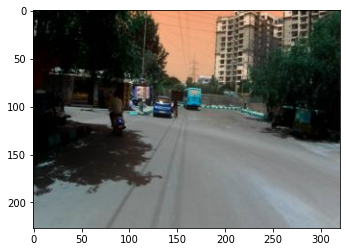

In [ ]:
img = cv2.imread(img_train+'29/972458_image.jpg',1)  
plt.imshow(img)

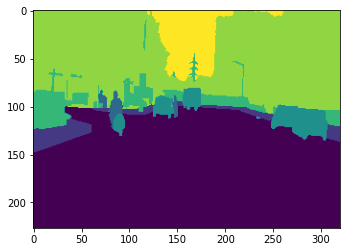

In [ ]:
def maskImage(imagepath):
    img = cv2.imread(imagepath,0)
    for i in range(len(img)):
        for j in range(len(img[0])):
            if img[i][j] != 0 or img[i][j] != 255:
                img[i][j] *= 40  
    return img
img = maskImage(seg_train+'29/972458_label.png')
plt.imshow(img)

In [ ]:
(IMG_HEIGHT,IMG_WIDTH) = (128,256)
N_CHANNELS = 3
N_CLASSES = 8 

TRAIN_SIZE= len(glob(img_train+'*/*_image.jpg'))
print("train size : ", TRAIN_SIZE)

VAL_SIZE = len(glob(img_val+'*/*_image.jpg'))
print("validation size : ", VAL_SIZE)

train size :  1403
validation size :  204


In [ ]:

def parse_image(img_path):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)

    mask_path = tf.strings.regex_replace(img_path, "leftImg8bit", "gtFine")
    mask_path = tf.strings.regex_replace(mask_path, "_image.jpg", "_label.png")

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.where(mask==255, np.dtype('uint8').type(7), mask)
    print(mask.shape)
    return {'image': image, 'segmentation_mask': mask}
#parse_image(img_train+'29/972458_image.jpg')

train_dataset_list = tf.data.Dataset.list_files(img_train+'*/*_image.jpg', seed=SEED)
train_dataset = train_dataset_list.map(parse_image)

val_dataset_list = tf.data.Dataset.list_files(img_val+'*/*_image.jpg', seed=SEED)
val_dataset = val_dataset_list.map(parse_image)


def load_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (IMG_HEIGHT, IMG_WIDTH))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_HEIGHT, IMG_WIDTH))
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

def load_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (IMG_HEIGHT, IMG_WIDTH))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_HEIGHT, IMG_WIDTH))
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

BATCH_SIZE = 32
BUFFER_SIZE = 1500
dataset = {"train": train_dataset, "val": val_dataset}

(None, None, 1)
(None, None, 1)


In [ ]:
dataset['train'] = dataset['train'].map(load_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=AUTOTUNE)
print(dataset['train'])

dataset['val'] = dataset['val'].map(load_test)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=AUTOTUNE)
print(dataset['val'])

<PrefetchDataset shapes: ((None, 128, 256, 3), (None, 128, 256, 1)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 128, 256, 3), (None, 128, 256, 1)), types: (tf.float32, tf.float32)>


In [ ]:
def display_sample(display_list):
    plt.figure(figsize=(15,15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

#for image, mask in dataset['train'].take(1):
#    sample_image, sample_mask = image, mask

#display_sample([sample_image[0], sample_mask[0]])

In [ ]:
class Downsampling(tf.keras.Model):
  
    def __init__(self, filter_size, block_number, initializer= None):
        super(Downsampling, self).__init__()
        self.block_number = block_number
        self.filter_size = filter_size
        self.max_pool_layer = MaxPooling2D(pool_size=(2,2))
        self.convolution_layer_1 = Convolution2D(self.filter_size, 3, activation = 'relu', padding='same', kernel_initializer=initializer)
        self.convolution_layer_2 = Convolution2D(self.filter_size, 3, activation = 'relu', padding='same', kernel_initializer=initializer)

    def call(self,inputs):
        if(self.block_number==1):
            x = self.convolution_layer_1(inputs)
            x = self.convolution_layer_2(x)
            return x
        x = self.max_pool_layer(inputs)
        x = self.convolution_layer_1(x)
        x = self.convolution_layer_2(x)
        return x

class Upsampling(tf.keras.Model):
    
    def __init__(self, filter_size, block_number, initializer= None):
        super(Upsampling, self).__init__()
        self.filter_size = filter_size
        self.block_number = block_number
        self.upsampling_layer = UpSampling2D(size=(2,2))
        self.convolution_layer_1 = Convolution2D(self.filter_size, 2, activation = 'relu', padding='same', kernel_initializer=initializer)
        self.convolution_layer_2 = Convolution2D(self.filter_size, 3, activation = 'relu', padding='same', kernel_initializer=initializer)
        self.convolution_layer_3 = Convolution2D(self.filter_size, 3, activation = 'relu', padding='same', kernel_initializer=initializer)
        self.convolution_layer_4 = Convolution2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)
    
    def call(self,inputs,upsampling_layer):
        x = self.convolution_layer_1(self.upsampling_layer(inputs))
        merged = concatenate([upsampling_layer,x], axis=3)
        x = self.convolution_layer_2(merged)
        x = self.convolution_layer_3(x)
        if(self.block_number==4):
            x = self.convolution_layer_4(x)
        return x

class segUnetModel(tf.keras.Model):
    
    def __init__(self, output_channels, initializer = None, dynamic=True):
        super(segUnetModel, self).__init__()
        self.output_channels = output_channels
        self.encoder_block_1 = Downsampling(64,1)
        self.encoder_block_2 = Downsampling(128,2)
        self.encoder_block_3 = Downsampling(256,3)
        self.encoder_block_4 = Downsampling(512,4)
        self.encoder_block_5 = Downsampling(1024,5)
        self.decoder_block_1 = Upsampling(512,1)
        self.decoder_block_2 = Upsampling(256,2)
        self.decoder_block_3 = Upsampling(128,3)
        self.decoder_block_4 = Upsampling(64,4)
        self.output_layer = Convolution2D(self.output_channels, 1, activation='softmax')
    
    def call(self,inputs):
        print("inputs",inputs)
        conv_enc_1 = self.encoder_block_1(inputs)
        conv_enc_2 = self.encoder_block_2(conv_enc_1)
        conv_enc_3 = self.encoder_block_3(conv_enc_2)
        conv_enc_4 = self.encoder_block_4(conv_enc_3)
        conv_enc_5 = self.encoder_block_5(conv_enc_4)

        conv_dec_1 = self.decoder_block_1(conv_enc_5,conv_enc_4)
        conv_dec_2 = self.decoder_block_2(conv_dec_1,conv_enc_3)
        conv_dec_3 = self.decoder_block_3(conv_dec_2,conv_enc_2)
        conv_dec_4 = self.decoder_block_4(conv_dec_3,conv_enc_1)
        output = self.output_layer(conv_dec_4)
        return output

model = segUnetModel(N_CLASSES)

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(ckpt, 'tf_ckpts/', max_to_keep=3)

train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('train_accuracy')
test_loss = tf.keras.metrics.Mean('test_loss', dtype=tf.float32)
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('test_accuracy')

In [ ]:
@tf.function
def train_step(model, optimizer, x_train, y_train):
    with tf.GradientTape() as tape:
        predictions = model(x_train, training=True)
        loss = loss_object(y_train, predictions)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    train_loss(loss)
    train_accuracy(y_train, predictions)


def train_and_checkpoint(model, manager, dataset, epoch):
    ckpt.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("Restored from {}".format(manager.latest_checkpoint))
    else:
        print("Initializing from scratch.")
    for (x_train, y_train) in dataset['train'].take(math.ceil(TRAIN_SIZE/BATCH_SIZE)):
        train_step(model, optimizer, x_train, y_train)
        return
    ckpt.step.assign_add(1)
    save_path = manager.save()
    print("Saved checkpoint for epoch {}: {}".format(epoch, save_path))
    
@tf.function
def test_step(model, x_test, y_test):
    predictions = model(x_test)
    loss = loss_object(y_test, predictions)
    test_loss(loss)
    test_accuracy(y_test, predictions)
    return predictions

train_log_dir = 'logs/gradient_tape/train'
test_log_dir = 'logs/gradient_tape/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [ ]:
highest_accuracy = 0
noEpochs = 1
startEpoch = 103
fields = ['Epoch', 'Loss', 'Acc', 'Val Loss', 'Val Acc'] 
filename = input("Enter File Name without type : ") + ".txt"
#paramsFile = open(filename, "w+")
#paramsFile.write(','.join(fields))
#paramsFile.write("\n")
#paramsFile.close()
for epoch in range(startEpoch, startEpoch + noEpochs):

    print("Epoch ",epoch+1)
    #delTrash()
    start = time.time()
    
    train_and_checkpoint(model, manager, dataset, epoch+1)
    break
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=ckpt.step.numpy())
        tf.summary.scalar('accuracy', train_accuracy.result(), step=ckpt.step.numpy())
    
    for (x_test, y_test) in dataset['val'].take(math.ceil(VAL_SIZE/BATCH_SIZE)):
        pred = test_step(model, x_test, y_test)
    
    with test_summary_writer.as_default():
        tf.summary.scalar('loss', test_loss.result(), step=ckpt.step.numpy())
        tf.summary.scalar('accuracy', test_accuracy.result(), step=ckpt.step.numpy())
    
    #print("Time taken ",time.time()-start)
    
    template = 'Epoch {}, Loss: {:.3f}, Accuracy: {:.3f}, Val Loss: {:.3f}, Val Accuracy: {:.3f}'
    otemp = '{}, {:.3f}, {:.3f}, {:.3f}, {:.3f}'
    print (template.format(epoch+1,
                            train_loss.result(), 
                            train_accuracy.result()*100,
                            test_loss.result(), 
                            test_accuracy.result()*100))
    text = otemp.format(epoch+1,
                            train_loss.result(), 
                            train_accuracy.result()*100,
                            test_loss.result(), 
                            test_accuracy.result()*100)
    paramsFile = open(filename, "a")
    paramsFile.write(text+"\n") 
    paramsFile.close()
    if(test_accuracy.result().numpy()*100>highest_accuracy):
        print("Validation accuracy increased from {:.3f} to {:.3f}. Saving model weights.".format(highest_accuracy,test_accuracy.result().numpy()*100))
        highest_accuracy = test_accuracy.result().numpy()*100
        model.save_weights('unet_weights-epoch-{}.hdf5'.format(epoch+1))

    print('_'*80)
    
    # Reset metrics after every epoch
    train_loss.reset_states()
    test_loss.reset_states()
    train_accuracy.reset_states()
    test_accuracy.reset_states()

Enter File Name without type : randomFile
Epoch  104
Restored from tf_ckpts/ckpt-119


In [ ]:

def IoU(y_i,y_pred):
    IoUs = []
    n_classes = 8
    for c in range(n_classes):
        TP = np.sum((y_i == c)&(y_pred==c))
        FP = np.sum((y_i != c)&(y_pred==c))
        FN = np.sum((y_i == c)&(y_pred!= c))
        IoU = TP/float(TP + FP + FN)
        if(math.isnan(IoU)):
            IoUs.append(0)
            continue
        IoUs.append(IoU)
    mIoU = np.mean(IoUs)
    return mIoU

def predict(model,image_path):
    datapoint = parse_image(image_path)
    input_image,image_mask = load_test(datapoint)
    img = tf.expand_dims(input_image, 0)
    prediction = model(img)
    prediction = tf.argmax(prediction, axis=-1)
    prediction = tf.squeeze(prediction, axis = 0)
    pred_mask = tf.expand_dims(prediction, axis=-1)
    return image_mask, pred_mask

In [ ]:
#ckpt.restore(manager.latest_checkpoint)
#model.built=True
model = segUnetModel(8)
model.build(input_shape=(None,128,128,3))
model.load_weights('Model3/unet_weights-epoch-87.hdf5')
true_mask, pred_mask = predict(model,'idd20k_lite/leftImg8bit/val/21/240284_image.jpg')
IoU(true_mask, pred_mask)
model.summary()

(227, 320, 1)
Model: "seg_unet_model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
downsampling_30 (Downsamplin multiple                  38720     
_________________________________________________________________
downsampling_31 (Downsamplin multiple                  221440    
_________________________________________________________________
downsampling_32 (Downsamplin multiple                  885248    
_________________________________________________________________
downsampling_33 (Downsamplin multiple                  3539968   
_________________________________________________________________
downsampling_34 (Downsamplin multiple                  14157824  
_________________________________________________________________
upsampling_24 (Upsampling)   multiple                  9176576   
_________________________________________________________________
upsampling_25 (Upsampling)   multipl

In [ ]:
#mask images
import cv2
import imutils

cap = cv2.VideoCapture(input("Enter file name"))
outputFile = input("Enter output file name")
ret, frame = cap.read()
frameNo = 1

out = cv2.VideoWriter(input("enter name.avi"),cv2.VideoWriter_fourcc('M','J','P','G'), 25, (IMG_WIDTH, IMG_HEIGHT))
while(1):
    ret, frame = cap.read()
    if ret == False :
        print("Done")
        break

   
    frame = imutils.rotate(frame, 270)
    #plt.imshow(frame)
 
    origFrame = cv2.resize(frame, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_CUBIC)
    #frame = frame[64:,:]
  
    origFrameCopy = origFrame.copy()
  
    frame = tf.image.convert_image_dtype(frame, tf.uint8)
    frame = tf.image.resize(frame, (IMG_HEIGHT, IMG_WIDTH))
    frame = tf.expand_dims(frame, 0)
    frame = tf.cast(frame, tf.float32) / 255.0
 
    prediction = model(frame)
    prediction = tf.argmax(prediction, axis=-1)
    prediction = tf.squeeze(prediction, axis = 0)
    prediction = tf.expand_dims(prediction, axis=-1)
    prediction = np.array(prediction)
    prediction[prediction == 7] = 255
    for i in range(origFrame.shape[0]) :
        for j in range(origFrame.shape[1]) :
            if prediction[i][j][0] == 0 or prediction[i][j][0] == 1 or prediction[i][j][0] == 2   :
                origFrameCopy[i][j] = [0, 150 ,0]
                
    #maskimage = addRoadMask(origFrame, prediction)
    alpha = 0.3
    cv2.addWeighted(origFrameCopy, alpha, origFrame, 1 - alpha, 0, origFrame)
    #cv2.imwrite(outputFile+"/"+"frame"+str(frameNo)+".jpg", origFrame)
    out.write(origFrame)
    frameNo += 1

cap.release()
out.release()

Enter file namesampleVid2.mp4
Enter output file namesampleVid2
enter name.avisampleVid2.avi
Done


In [ ]:
img_val = dataset_path + 'leftImg8bit/val/'
val_paths = glob(img_val+'*/*_image.jpg')
mIoU = []
for path in val_paths:
    true_mask, pred_mask = predict(model,path)
    mIoU.append(IoU(true_mask, pred_mask))
print("Validation mIoU = ",sum(mIoU)/len(mIoU))

(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 320, 1)
(227, 

In [ ]:
img_test = dataset_path + 'leftImg8bit/test/'
test_paths = glob(img_test+'*/*_image.jpg')

test_images_final = []
test_images_name = []
orig_image_list = []
for imagePath in test_paths:
    image = cv2.imread(imagePath)
    orig_image_list.append(cv2.resize(image, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_CUBIC))
    make = imagePath.split("/")[-1]
    filename = make[:make.rfind("_")]
    make_new = imagePath.split("/")[-2]  
    directory="output/"+ make_new
    if not os.path.exists(directory):
        os.makedirs(directory)
    image_name = "output/"+ make_new+"/"+filename+"_label.png"
    test_images_final.append(image)
    test_images_name.append(image_name)

test_images_final = np.array(test_images_final)

test_images_final.shape

(404, 227, 320, 3)

In [ ]:
def addRoadMask(img, pred) :
    for i in range(img.shape[0]) :
        for j in range(img.shape[1]) :
            if pred[i][j][0] == 0 or pred[i][j][0] == 1 or pred[i][j][0] == 2   :
                img[i][j] = 0
    return img 

for i,image in enumerate(test_images_final):
    image = tf.image.convert_image_dtype(image, tf.uint8)
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    image = tf.expand_dims(image, 0)
    prediction = model(image)
    prediction = tf.argmax(prediction, axis=-1)
    prediction = tf.squeeze(prediction, axis = 0)
    prediction = tf.expand_dims(prediction, axis=-1)
    prediction = np.array(prediction)
    prediction[prediction == 7] = 255

    origFrameCopy = orig_image_list[i].copy()
    for i in range(orig_image_list[i].shape[0]) :
        for j in range(orig_image_list[i].shape[1]) :
            if prediction[i][j][0] == 0 or prediction[i][j][0] == 1 or prediction[i][j][0] == 2   :
                origFrameCopy[i][j] = [127, 0 ,255]
            
    #maskimage = addRoadMask(origFrame, prediction)
    alpha = 0.5
    cv2.addWeighted(origFrameCopy, alpha, orig_image_list[i], 1 - alpha, 0, orig_image_list[i])
  
    #maskimage = addRoadMask(orig_image_list[i], prediction)
    cv2.imwrite(test_images_name[i], orig_image_list[i])

RuntimeError: ignored

In [ ]:
s'''
Enter File Name without type : Model4_No_kern_init
Epoch  1
Initializing from scratch.
Saved checkpoint for epoch 1: tf_ckpts/ckpt-1
Time taken  131.70299434661865
Epoch 1, Loss: 2.019, Accuracy: 22.205, Val Loss: 1.949, Val Accuracy: 31.768
Validation accuracy increased from 0.000 to 31.768. Saving model weights.
________________________________________________________________________________
Epoch  2
Restored from tf_ckpts/ckpt-1
Saved checkpoint for epoch 2: tf_ckpts/ckpt-2
Time taken  48.56461691856384
Epoch 2, Loss: 1.818, Accuracy: 41.501, Val Loss: 1.777, Val Accuracy: 39.260
Validation accuracy increased from 31.768 to 39.260. Saving model weights.
________________________________________________________________________________
Epoch  3
Restored from tf_ckpts/ckpt-2
Saved checkpoint for epoch 3: tf_ckpts/ckpt-3
Time taken  48.2021267414093
Epoch 3, Loss: 1.734, Accuracy: 39.819, Val Loss: 1.660, Val Accuracy: 39.909
Validation accuracy increased from 39.260 to 39.909. Saving model weights.
________________________________________________________________________________
Epoch  4
Restored from tf_ckpts/ckpt-3
Saved checkpoint for epoch 4: tf_ckpts/ckpt-4
Time taken  49.43944239616394
Epoch 4, Loss: 1.665, Accuracy: 38.930, Val Loss: 1.614, Val Accuracy: 31.176
________________________________________________________________________________
Epoch  5
Restored from tf_ckpts/ckpt-4
Saved checkpoint for epoch 5: tf_ckpts/ckpt-5
Time taken  49.139031410217285
Epoch 5, Loss: 1.656, Accuracy: 45.569, Val Loss: 1.612, Val Accuracy: 49.666
Validation accuracy increased from 39.909 to 49.666. Saving model weights.
________________________________________________________________________________
Epoch  6
Restored from tf_ckpts/ckpt-5
Saved checkpoint for epoch 6: tf_ckpts/ckpt-6
Time taken  49.33945679664612
Epoch 6, Loss: 1.593, Accuracy: 53.694, Val Loss: 1.512, Val Accuracy: 55.368
Validation accuracy increased from 49.666 to 55.368. Saving model weights.
________________________________________________________________________________
Epoch  7
Restored from tf_ckpts/ckpt-6
Saved checkpoint for epoch 7: tf_ckpts/ckpt-7
Time taken  50.113372564315796
Epoch 7, Loss: 1.477, Accuracy: 54.853, Val Loss: 1.435, Val Accuracy: 56.090
Validation accuracy increased from 55.368 to 56.090. Saving model weights.
________________________________________________________________________________
Epoch  8
Restored from tf_ckpts/ckpt-7
Saved checkpoint for epoch 8: tf_ckpts/ckpt-8
Time taken  50.04258346557617
Epoch 8, Loss: 1.385, Accuracy: 63.483, Val Loss: 1.328, Val Accuracy: 69.787
Validation accuracy increased from 56.090 to 69.787. Saving model weights.
________________________________________________________________________________
Epoch  9
Restored from tf_ckpts/ckpt-8
Saved checkpoint for epoch 9: tf_ckpts/ckpt-9
Time taken  49.53114414215088
Epoch 9, Loss: 1.286, Accuracy: 70.793, Val Loss: 1.277, Val Accuracy: 69.403
________________________________________________________________________________
Epoch  10
Restored from tf_ckpts/ckpt-9
Saved checkpoint for epoch 10: tf_ckpts/ckpt-10
Time taken  50.22846341133118
Epoch 10, Loss: 1.221, Accuracy: 71.243, Val Loss: 1.197, Val Accuracy: 70.457
Validation accuracy increased from 69.787 to 70.457. Saving model weights.
________________________________________________________________________________
Epoch  11
Restored from tf_ckpts/ckpt-10
Saved checkpoint for epoch 11: tf_ckpts/ckpt-11
Time taken  50.46635317802429
Epoch 11, Loss: 1.173, Accuracy: 71.809, Val Loss: 1.175, Val Accuracy: 70.175
________________________________________________________________________________
Epoch  12
Restored from tf_ckpts/ckpt-11
Saved checkpoint for epoch 12: tf_ckpts/ckpt-12
Time taken  50.31588292121887
Epoch 12, Loss: 1.150, Accuracy: 71.896, Val Loss: 1.155, Val Accuracy: 70.233
________________________________________________________________________________
Epoch  13
Restored from tf_ckpts/ckpt-12
Saved checkpoint for epoch 13: tf_ckpts/ckpt-13
Time taken  50.32484245300293
Epoch 13, Loss: 1.119, Accuracy: 72.088, Val Loss: 1.128, Val Accuracy: 70.497
Validation accuracy increased from 70.457 to 70.497. Saving model weights.
________________________________________________________________________________
Epoch  14
Restored from tf_ckpts/ckpt-13
Saved checkpoint for epoch 14: tf_ckpts/ckpt-14
Time taken  49.746803760528564
Epoch 14, Loss: 1.095, Accuracy: 72.211, Val Loss: 1.104, Val Accuracy: 70.491
________________________________________________________________________________
Epoch  15
Restored from tf_ckpts/ckpt-14
Saved checkpoint for epoch 15: tf_ckpts/ckpt-15
Time taken  50.26936984062195
Epoch 15, Loss: 1.070, Accuracy: 72.410, Val Loss: 1.086, Val Accuracy: 70.262
________________________________________________________________________________
Epoch  16
Restored from tf_ckpts/ckpt-15
Saved checkpoint for epoch 16: tf_ckpts/ckpt-16
Time taken  49.797401428222656
Epoch 16, Loss: 1.043, Accuracy: 72.571, Val Loss: 1.055, Val Accuracy: 70.901
Validation accuracy increased from 70.497 to 70.901. Saving model weights.
________________________________________________________________________________
Epoch  17
Restored from tf_ckpts/ckpt-16
Saved checkpoint for epoch 17: tf_ckpts/ckpt-17
Time taken  50.34720730781555
Epoch 17, Loss: 1.017, Accuracy: 72.740, Val Loss: 1.035, Val Accuracy: 71.030
Validation accuracy increased from 70.901 to 71.030. Saving model weights.
________________________________________________________________________________
Epoch  18
Restored from tf_ckpts/ckpt-17
Saved checkpoint for epoch 18: tf_ckpts/ckpt-18
Time taken  50.38612699508667
Epoch 18, Loss: 1.000, Accuracy: 72.843, Val Loss: 1.021, Val Accuracy: 70.803
________________________________________________________________________________
Epoch  19
Restored from tf_ckpts/ckpt-18
Saved checkpoint for epoch 19: tf_ckpts/ckpt-19
Time taken  50.14388966560364
Epoch 19, Loss: 0.980, Accuracy: 72.848, Val Loss: 1.012, Val Accuracy: 70.985
________________________________________________________________________________
Epoch  20
Restored from tf_ckpts/ckpt-19
Saved checkpoint for epoch 20: tf_ckpts/ckpt-20
Time taken  50.25280046463013
Epoch 20, Loss: 0.959, Accuracy: 72.996, Val Loss: 0.989, Val Accuracy: 70.753
________________________________________________________________________________
Epoch  21
Restored from tf_ckpts/ckpt-20
Saved checkpoint for epoch 21: tf_ckpts/ckpt-21
Time taken  50.006041049957275
Epoch 21, Loss: 0.948, Accuracy: 72.893, Val Loss: 1.042, Val Accuracy: 70.225
________________________________________________________________________________
Epoch  22
Restored from tf_ckpts/ckpt-21
Saved checkpoint for epoch 22: tf_ckpts/ckpt-22
Time taken  50.34022378921509
Epoch 22, Loss: 0.955, Accuracy: 72.590, Val Loss: 0.962, Val Accuracy: 70.997
________________________________________________________________________________
Epoch  23
Restored from tf_ckpts/ckpt-22
Saved checkpoint for epoch 23: tf_ckpts/ckpt-23
Time taken  49.73620796203613
Epoch 23, Loss: 0.921, Accuracy: 72.897, Val Loss: 0.941, Val Accuracy: 71.231
Validation accuracy increased from 71.030 to 71.231. Saving model weights.
________________________________________________________________________________
Epoch  24
Restored from tf_ckpts/ckpt-23
Saved checkpoint for epoch 24: tf_ckpts/ckpt-24
Time taken  49.739721059799194
Epoch 24, Loss: 0.896, Accuracy: 73.124, Val Loss: 0.925, Val Accuracy: 70.647
________________________________________________________________________________
Epoch  25
Restored from tf_ckpts/ckpt-24
Saved checkpoint for epoch 25: tf_ckpts/ckpt-25
Time taken  49.71016240119934
Epoch 25, Loss: 0.875, Accuracy: 73.231, Val Loss: 0.926, Val Accuracy: 71.416
Validation accuracy increased from 71.231 to 71.416. Saving model weights.
________________________________________________________________________________
Epoch  26
Restored from tf_ckpts/ckpt-25
Saved checkpoint for epoch 26: tf_ckpts/ckpt-26
Time taken  49.88245868682861
Epoch 26, Loss: 0.863, Accuracy: 73.280, Val Loss: 0.900, Val Accuracy: 71.867
Validation accuracy increased from 71.416 to 71.867. Saving model weights.
________________________________________________________________________________
Epoch  27
Restored from tf_ckpts/ckpt-26
Saved checkpoint for epoch 27: tf_ckpts/ckpt-27
Time taken  50.32709193229675
Epoch 27, Loss: 0.837, Accuracy: 75.232, Val Loss: 0.871, Val Accuracy: 74.178
Validation accuracy increased from 71.867 to 74.178. Saving model weights.
________________________________________________________________________________
Epoch  28
Restored from tf_ckpts/ckpt-27
Saved checkpoint for epoch 28: tf_ckpts/ckpt-28
Time taken  51.27691602706909
Epoch 28, Loss: 0.819, Accuracy: 76.026, Val Loss: 0.859, Val Accuracy: 74.581
Validation accuracy increased from 74.178 to 74.581. Saving model weights.
________________________________________________________________________________
Epoch  29
Restored from tf_ckpts/ckpt-28
Saved checkpoint for epoch 29: tf_ckpts/ckpt-29
Time taken  49.94914436340332
Epoch 29, Loss: 0.803, Accuracy: 76.357, Val Loss: 0.844, Val Accuracy: 74.822
Validation accuracy increased from 74.581 to 74.822. Saving model weights.
________________________________________________________________________________
Epoch  30
Restored from tf_ckpts/ckpt-29
Saved checkpoint for epoch 30: tf_ckpts/ckpt-30
Time taken  50.53544497489929
Epoch 30, Loss: 0.801, Accuracy: 76.343, Val Loss: 0.820, Val Accuracy: 75.011
Validation accuracy increased from 74.822 to 75.011. Saving model weights.
________________________________________________________________________________
Epoch  31
Restored from tf_ckpts/ckpt-30
Saved checkpoint for epoch 31: tf_ckpts/ckpt-31
Time taken  50.256569147109985
Epoch 31, Loss: 0.774, Accuracy: 76.876, Val Loss: 0.831, Val Accuracy: 74.829
________________________________________________________________________________
Epoch  32
Restored from tf_ckpts/ckpt-31
Saved checkpoint for epoch 32: tf_ckpts/ckpt-32
Time taken  50.205477476119995
Epoch 32, Loss: 0.774, Accuracy: 76.877, Val Loss: 0.806, Val Accuracy: 75.211
Validation accuracy increased from 75.011 to 75.211. Saving model weights.
________________________________________________________________________________
Epoch  33
Restored from tf_ckpts/ckpt-32
Saved checkpoint for epoch 33: tf_ckpts/ckpt-33
Time taken  50.7087185382843
Epoch 33, Loss: 0.749, Accuracy: 77.575, Val Loss: 0.794, Val Accuracy: 75.830
Validation accuracy increased from 75.211 to 75.830. Saving model weights.
________________________________________________________________________________
Epoch  34
Restored from tf_ckpts/ckpt-33
Saved checkpoint for epoch 34: tf_ckpts/ckpt-34
Time taken  50.109997272491455
Epoch 34, Loss: 0.735, Accuracy: 78.236, Val Loss: 0.795, Val Accuracy: 76.277
Validation accuracy increased from 75.830 to 76.277. Saving model weights.
________________________________________________________________________________
Epoch  35
Restored from tf_ckpts/ckpt-34
Saved checkpoint for epoch 35: tf_ckpts/ckpt-35
Time taken  50.5668580532074
Epoch 35, Loss: 0.710, Accuracy: 79.428, Val Loss: 0.770, Val Accuracy: 76.841
Validation accuracy increased from 76.277 to 76.841. Saving model weights.
________________________________________________________________________________
Epoch  36
Restored from tf_ckpts/ckpt-35
Saved checkpoint for epoch 36: tf_ckpts/ckpt-36
Time taken  50.19400238990784
Epoch 36, Loss: 0.697, Accuracy: 79.609, Val Loss: 0.752, Val Accuracy: 77.553
Validation accuracy increased from 76.841 to 77.553. Saving model weights.
________________________________________________________________________________
Epoch  37
Restored from tf_ckpts/ckpt-36
Saved checkpoint for epoch 37: tf_ckpts/ckpt-37
Time taken  50.113327503204346
Epoch 37, Loss: 0.686, Accuracy: 79.892, Val Loss: 0.751, Val Accuracy: 76.704
________________________________________________________________________________
Epoch  38
Restored from tf_ckpts/ckpt-37
Saved checkpoint for epoch 38: tf_ckpts/ckpt-38
Time taken  50.538169860839844
Epoch 38, Loss: 0.670, Accuracy: 80.233, Val Loss: 0.726, Val Accuracy: 78.176
Validation accuracy increased from 77.553 to 78.176. Saving model weights.
________________________________________________________________________________
Epoch  39
Restored from tf_ckpts/ckpt-38
Saved checkpoint for epoch 39: tf_ckpts/ckpt-39
Time taken  50.52647590637207
Epoch 39, Loss: 0.653, Accuracy: 80.641, Val Loss: 0.717, Val Accuracy: 77.596
________________________________________________________________________________
Epoch  40
Restored from tf_ckpts/ckpt-39
Saved checkpoint for epoch 40: tf_ckpts/ckpt-40
Time taken  50.10612773895264
Epoch 40, Loss: 0.662, Accuracy: 79.885, Val Loss: 0.737, Val Accuracy: 76.771
________________________________________________________________________________
Epoch  41
Restored from tf_ckpts/ckpt-40
Saved checkpoint for epoch 41: tf_ckpts/ckpt-41
Time taken  49.86799430847168
Epoch 41, Loss: 0.635, Accuracy: 80.734, Val Loss: 0.711, Val Accuracy: 78.304
Validation accuracy increased from 78.176 to 78.304. Saving model weights.
________________________________________________________________________________
Epoch  42
Restored from tf_ckpts/ckpt-41
Saved checkpoint for epoch 42: tf_ckpts/ckpt-42
Time taken  50.80489945411682
Epoch 42, Loss: 0.639, Accuracy: 80.231, Val Loss: 0.697, Val Accuracy: 78.197
________________________________________________________________________________
Epoch  43
Restored from tf_ckpts/ckpt-42
Saved checkpoint for epoch 43: tf_ckpts/ckpt-43
Time taken  50.87130570411682
Epoch 43, Loss: 0.608, Accuracy: 81.196, Val Loss: 0.834, Val Accuracy: 77.552
________________________________________________________________________________
Epoch  44
Restored from tf_ckpts/ckpt-43
Saved checkpoint for epoch 44: tf_ckpts/ckpt-44
Time taken  49.89110326766968
Epoch 44, Loss: 0.624, Accuracy: 80.523, Val Loss: 0.688, Val Accuracy: 78.027
________________________________________________________________________________
Epoch  45
Restored from tf_ckpts/ckpt-44
Saved checkpoint for epoch 45: tf_ckpts/ckpt-45
Time taken  50.63417458534241
Epoch 45, Loss: 0.606, Accuracy: 80.923, Val Loss: 0.679, Val Accuracy: 78.705
Validation accuracy increased from 78.304 to 78.705. Saving model weights.
________________________________________________________________________________
Epoch  46
Restored from tf_ckpts/ckpt-45
Saved checkpoint for epoch 46: tf_ckpts/ckpt-46
Time taken  50.41448903083801
Epoch 46, Loss: 0.581, Accuracy: 81.530, Val Loss: 0.682, Val Accuracy: 78.214
________________________________________________________________________________
Epoch  47
Restored from tf_ckpts/ckpt-46
Saved checkpoint for epoch 47: tf_ckpts/ckpt-47
Time taken  49.97457242012024
Epoch 47, Loss: 0.573, Accuracy: 81.648, Val Loss: 0.655, Val Accuracy: 79.306
Validation accuracy increased from 78.705 to 79.306. Saving model weights.
________________________________________________________________________________
Epoch  48
Restored from tf_ckpts/ckpt-47
Saved checkpoint for epoch 48: tf_ckpts/ckpt-48
Time taken  50.77099013328552
Epoch 48, Loss: 0.558, Accuracy: 82.029, Val Loss: 0.651, Val Accuracy: 78.702
________________________________________________________________________________
Epoch  49
Restored from tf_ckpts/ckpt-48
Saved checkpoint for epoch 49: tf_ckpts/ckpt-49
Time taken  50.133535385131836
Epoch 49, Loss: 0.548, Accuracy: 82.197, Val Loss: 0.657, Val Accuracy: 79.103
________________________________________________________________________________
Epoch  50
Restored from tf_ckpts/ckpt-49
Saved checkpoint for epoch 50: tf_ckpts/ckpt-50
Time taken  50.62588381767273
Epoch 50, Loss: 0.534, Accuracy: 82.431, Val Loss: 0.644, Val Accuracy: 78.969
________________________________________________________________________________
Epoch  51
Restored from tf_ckpts/ckpt-50
Saved checkpoint for epoch 51: tf_ckpts/ckpt-51
Time taken  50.22106337547302
Epoch 51, Loss: 0.542, Accuracy: 82.061, Val Loss: 0.669, Val Accuracy: 78.194
________________________________________________________________________________
Epoch  52
Restored from tf_ckpts/ckpt-51
Saved checkpoint for epoch 52: tf_ckpts/ckpt-52
Time taken  49.991535663604736
Epoch 52, Loss: 0.539, Accuracy: 82.034, Val Loss: 0.633, Val Accuracy: 79.384
Validation accuracy increased from 79.306 to 79.384. Saving model weights.
________________________________________________________________________________
Epoch  53
Restored from tf_ckpts/ckpt-52
Saved checkpoint for epoch 53: tf_ckpts/ckpt-53
Time taken  50.69082689285278
Epoch 53, Loss: 0.515, Accuracy: 82.724, Val Loss: 0.633, Val Accuracy: 79.960
Validation accuracy increased from 79.384 to 79.960. Saving model weights.
________________________________________________________________________________
Epoch  54
Restored from tf_ckpts/ckpt-53
Saved checkpoint for epoch 54: tf_ckpts/ckpt-54
Time taken  50.35631036758423
Epoch 54, Loss: 0.502, Accuracy: 82.945, Val Loss: 0.634, Val Accuracy: 79.703
________________________________________________________________________________
Epoch  55
Restored from tf_ckpts/ckpt-54
Saved checkpoint for epoch 55: tf_ckpts/ckpt-55
Time taken  50.747395515441895
Epoch 55, Loss: 0.501, Accuracy: 82.912, Val Loss: 0.627, Val Accuracy: 80.120
Validation accuracy increased from 79.960 to 80.120. Saving model weights.
________________________________________________________________________________
Epoch  56
Restored from tf_ckpts/ckpt-55
Saved checkpoint for epoch 56: tf_ckpts/ckpt-56
Time taken  50.79971432685852
Epoch 56, Loss: 0.490, Accuracy: 83.115, Val Loss: 0.602, Val Accuracy: 79.762
________________________________________________________________________________
Epoch  57
Restored from tf_ckpts/ckpt-56
Saved checkpoint for epoch 57: tf_ckpts/ckpt-57
Time taken  50.0770742893219
Epoch 57, Loss: 0.476, Accuracy: 83.460, Val Loss: 0.605, Val Accuracy: 79.653
________________________________________________________________________________
Epoch  58
Restored from tf_ckpts/ckpt-57
Saved checkpoint for epoch 58: tf_ckpts/ckpt-58
Time taken  50.56035900115967
Epoch 58, Loss: 0.505, Accuracy: 82.557, Val Loss: 0.640, Val Accuracy: 79.651
________________________________________________________________________________
Epoch  59
Restored from tf_ckpts/ckpt-58
Saved checkpoint for epoch 59: tf_ckpts/ckpt-59
Time taken  50.35398840904236
Epoch 59, Loss: 0.485, Accuracy: 83.051, Val Loss: 0.590, Val Accuracy: 79.963
________________________________________________________________________________
Epoch  60
Restored from tf_ckpts/ckpt-59
Saved checkpoint for epoch 60: tf_ckpts/ckpt-60
Time taken  50.99105429649353
Epoch 60, Loss: 0.463, Accuracy: 83.647, Val Loss: 0.582, Val Accuracy: 80.428
Validation accuracy increased from 80.120 to 80.428. Saving model weights.
________________________________________________________________________________
Epoch  61
Restored from tf_ckpts/ckpt-60
Saved checkpoint for epoch 61: tf_ckpts/ckpt-61
Time taken  50.461525201797485
Epoch 61, Loss: 0.472, Accuracy: 83.262, Val Loss: 0.601, Val Accuracy: 79.741
________________________________________________________________________________
Epoch  62
Restored from tf_ckpts/ckpt-61
Saved checkpoint for epoch 62: tf_ckpts/ckpt-62
Time taken  50.408541202545166
Epoch 62, Loss: 0.488, Accuracy: 82.699, Val Loss: 0.651, Val Accuracy: 78.730
________________________________________________________________________________
Epoch  63
Restored from tf_ckpts/ckpt-62
Saved checkpoint for epoch 63: tf_ckpts/ckpt-63
Time taken  50.47708034515381
Epoch 63, Loss: 0.509, Accuracy: 82.062, Val Loss: 0.587, Val Accuracy: 79.972
________________________________________________________________________________
Epoch  64
Restored from tf_ckpts/ckpt-63
Saved checkpoint for epoch 64: tf_ckpts/ckpt-64
Time taken  50.128114461898804
Epoch 64, Loss: 0.457, Accuracy: 83.512, Val Loss: 0.580, Val Accuracy: 80.234
________________________________________________________________________________
Epoch  65
Restored from tf_ckpts/ckpt-64
Saved checkpoint for epoch 65: tf_ckpts/ckpt-65
Time taken  50.57874655723572
Epoch 65, Loss: 0.443, Accuracy: 83.878, Val Loss: 0.568, Val Accuracy: 80.665
Validation accuracy increased from 80.428 to 80.665. Saving model weights.
________________________________________________________________________________
Epoch  66
Restored from tf_ckpts/ckpt-65
Saved checkpoint for epoch 66: tf_ckpts/ckpt-66
Time taken  51.08372449874878
Epoch 66, Loss: 0.431, Accuracy: 84.131, Val Loss: 0.607, Val Accuracy: 79.900
________________________________________________________________________________
Epoch  67
Restored from tf_ckpts/ckpt-66
Saved checkpoint for epoch 67: tf_ckpts/ckpt-67
Time taken  51.07873320579529
Epoch 67, Loss: 0.436, Accuracy: 83.989, Val Loss: 0.584, Val Accuracy: 80.508
________________________________________________________________________________
Epoch  68
Restored from tf_ckpts/ckpt-67
Saved checkpoint for epoch 68: tf_ckpts/ckpt-68
Time taken  50.61835718154907
Epoch 68, Loss: 0.426, Accuracy: 84.200, Val Loss: 0.577, Val Accuracy: 80.288
________________________________________________________________________________
Epoch  69
Restored from tf_ckpts/ckpt-68
Saved checkpoint for epoch 69: tf_ckpts/ckpt-69
Time taken  50.016807079315186
Epoch 69, Loss: 0.416, Accuracy: 84.464, Val Loss: 0.567, Val Accuracy: 80.763
Validation accuracy increased from 80.665 to 80.763. Saving model weights.
________________________________________________________________________________
Epoch  70
---------------------------------------------------------------------------
FileNotFoundError                         Traceback (most recent call last)
/usr/local/lib/python3.7/dist-packages/oauth2client/clientsecrets.py in _loadfile(filename)
    120     try:
--> 121         with open(filename, 'r') as fp:
    122             obj = json.load(fp)

FileNotFoundError: [Errno 2] No such file or directory: 'client_secrets.json'

During handling of the above exception, another exception occurred:

InvalidClientSecretsError                 Traceback (most recent call last)
11 frames
InvalidClientSecretsError: ('Error opening file', 'client_secrets.json', 'No such file or directory', 2)

During handling of the above exception, another exception occurred:

InvalidConfigError                        Traceback (most recent call last)
/usr/local/lib/python3.7/dist-packages/pydrive/auth.py in LoadClientConfigFile(self, client_config_file)
    386       client_type, client_info = clientsecrets.loadfile(client_config_file)
    387     except clientsecrets.InvalidClientSecretsError as error:
--> 388       raise InvalidConfigError('Invalid client secrets file %s' % error)
    389     if not client_type in (clientsecrets.TYPE_WEB,
    390                            clientsecrets.TYPE_INSTALLED):

InvalidConfigError: Invalid client secrets file ('Error opening file', 'client_secrets.json', 'No such file or directory', 2)
'''
'''
Enter File Name without type : Model4_No_kern_init
Epoch  70
Restored from tf_ckpts/ckpt-69
Saved checkpoint for epoch 70: tf_ckpts/ckpt-70
Time taken  124.86790418624878
Epoch 70, Loss: 0.417, Accuracy: 84.364, Val Loss: 0.610, Val Accuracy: 80.066
Validation accuracy increased from 0.000 to 80.066. Saving model weights.
________________________________________________________________________________
Epoch  71
Restored from tf_ckpts/ckpt-70
Saved checkpoint for epoch 71: tf_ckpts/ckpt-71
Time taken  53.41086483001709
Epoch 71, Loss: 0.415, Accuracy: 84.351, Val Loss: 0.577, Val Accuracy: 80.693
Validation accuracy increased from 80.066 to 80.693. Saving model weights.
________________________________________________________________________________
Epoch  72
Restored from tf_ckpts/ckpt-71
Saved checkpoint for epoch 72: tf_ckpts/ckpt-72
Time taken  52.283207654953
Epoch 72, Loss: 0.413, Accuracy: 84.402, Val Loss: 0.578, Val Accuracy: 80.745
Validation accuracy increased from 80.693 to 80.745. Saving model weights.
________________________________________________________________________________
Epoch  73
Restored from tf_ckpts/ckpt-72
Saved checkpoint for epoch 73: tf_ckpts/ckpt-73
Time taken  53.53682899475098
Epoch 73, Loss: 0.420, Accuracy: 84.114, Val Loss: 0.575, Val Accuracy: 80.588
________________________________________________________________________________
Epoch  74
Restored from tf_ckpts/ckpt-73
Saved checkpoint for epoch 74: tf_ckpts/ckpt-74
Time taken  52.37660050392151
Epoch 74, Loss: 0.405, Accuracy: 84.535, Val Loss: 0.563, Val Accuracy: 81.117
Validation accuracy increased from 80.745 to 81.117. Saving model weights.
________________________________________________________________________________
Epoch  75
Restored from tf_ckpts/ckpt-74
Saved checkpoint for epoch 75: tf_ckpts/ckpt-75
Time taken  52.55681252479553
Epoch 75, Loss: 0.390, Accuracy: 84.924, Val Loss: 0.562, Val Accuracy: 80.488
________________________________________________________________________________
Epoch  76
Restored from tf_ckpts/ckpt-75
Saved checkpoint for epoch 76: tf_ckpts/ckpt-76
Time taken  52.7660231590271
Epoch 76, Loss: 0.387, Accuracy: 84.982, Val Loss: 0.566, Val Accuracy: 80.673
________________________________________________________________________________
Epoch  77
Restored from tf_ckpts/ckpt-76
Saved checkpoint for epoch 77: tf_ckpts/ckpt-77
Time taken  53.28905916213989
Epoch 77, Loss: 0.379, Accuracy: 85.150, Val Loss: 0.580, Val Accuracy: 81.018
________________________________________________________________________________
Epoch  78
Restored from tf_ckpts/ckpt-77
Saved checkpoint for epoch 78: tf_ckpts/ckpt-78
Time taken  53.289321184158325
Epoch 78, Loss: 0.372, Accuracy: 85.320, Val Loss: 0.557, Val Accuracy: 81.079
________________________________________________________________________________
Epoch  79
Restored from tf_ckpts/ckpt-78
Saved checkpoint for epoch 79: tf_ckpts/ckpt-79
Time taken  53.09811568260193
Epoch 79, Loss: 0.365, Accuracy: 85.509, Val Loss: 0.579, Val Accuracy: 81.008
________________________________________________________________________________
Epoch  80
Restored from tf_ckpts/ckpt-79
Saved checkpoint for epoch 80: tf_ckpts/ckpt-80
Time taken  52.23091173171997
Epoch 80, Loss: 0.360, Accuracy: 85.605, Val Loss: 0.583, Val Accuracy: 81.211
Validation accuracy increased from 81.117 to 81.211. Saving model weights.
________________________________________________________________________________
Epoch  81
Restored from tf_ckpts/ckpt-80
Saved checkpoint for epoch 81: tf_ckpts/ckpt-81
Time taken  52.680081367492676
Epoch 81, Loss: 0.356, Accuracy: 85.717, Val Loss: 0.596, Val Accuracy: 80.730
________________________________________________________________________________
Epoch  82
Restored from tf_ckpts/ckpt-81
Saved checkpoint for epoch 82: tf_ckpts/ckpt-82
Time taken  52.23619818687439
Epoch 82, Loss: 0.358, Accuracy: 85.600, Val Loss: 0.608, Val Accuracy: 80.700
________________________________________________________________________________
Epoch  83
Restored from tf_ckpts/ckpt-82
Saved checkpoint for epoch 83: tf_ckpts/ckpt-83
Time taken  52.98617887496948
Epoch 83, Loss: 0.354, Accuracy: 85.693, Val Loss: 0.602, Val Accuracy: 81.007
________________________________________________________________________________
Epoch  84
Restored from tf_ckpts/ckpt-83
Saved checkpoint for epoch 84: tf_ckpts/ckpt-84
Time taken  52.94303870201111
Epoch 84, Loss: 0.369, Accuracy: 85.606, Val Loss: 0.613, Val Accuracy: 80.155
________________________________________________________________________________
Epoch  85
Restored from tf_ckpts/ckpt-84
Saved checkpoint for epoch 85: tf_ckpts/ckpt-85
Time taken  53.06806397438049
Epoch 85, Loss: 0.437, Accuracy: 83.128, Val Loss: 0.570, Val Accuracy: 79.326
________________________________________________________________________________
Epoch  86
Restored from tf_ckpts/ckpt-85
Saved checkpoint for epoch 86: tf_ckpts/ckpt-86
Time taken  52.452704429626465
Epoch 86, Loss: 0.403, Accuracy: 84.213, Val Loss: 0.611, Val Accuracy: 78.915
________________________________________________________________________________
Epoch  87
Restored from tf_ckpts/ckpt-86
Saved checkpoint for epoch 87: tf_ckpts/ckpt-87
Time taken  51.89831256866455
Epoch 87, Loss: 0.399, Accuracy: 84.248, Val Loss: 0.555, Val Accuracy: 80.783
________________________________________________________________________________
Epoch  88
Restored from tf_ckpts/ckpt-87
Saved checkpoint for epoch 88: tf_ckpts/ckpt-88
Time taken  52.63105273246765
Epoch 88, Loss: 0.365, Accuracy: 85.307, Val Loss: 0.557, Val Accuracy: 81.319
Validation accuracy increased from 81.211 to 81.319. Saving model weights.
________________________________________________________________________________
Epoch  89
Restored from tf_ckpts/ckpt-88
Saved checkpoint for epoch 89: tf_ckpts/ckpt-89
Time taken  52.316720724105835
Epoch 89, Loss: 0.349, Accuracy: 86.103, Val Loss: 0.601, Val Accuracy: 81.383
Validation accuracy increased from 81.319 to 81.383. Saving model weights.
________________________________________________________________________________
Epoch  90
Restored from tf_ckpts/ckpt-89
Saved checkpoint for epoch 90: tf_ckpts/ckpt-90
Time taken  53.050670862197876
Epoch 90, Loss: 0.337, Accuracy: 86.525, Val Loss: 0.578, Val Accuracy: 81.172
________________________________________________________________________________
Epoch  91
Restored from tf_ckpts/ckpt-90
Saved checkpoint for epoch 91: tf_ckpts/ckpt-91
Time taken  52.49787950515747
Epoch 91, Loss: 0.356, Accuracy: 85.769, Val Loss: 0.578, Val Accuracy: 80.515
________________________________________________________________________________
Epoch  92
Restored from tf_ckpts/ckpt-91
Saved checkpoint for epoch 92: tf_ckpts/ckpt-92
Time taken  52.214980363845825
Epoch 92, Loss: 0.365, Accuracy: 85.444, Val Loss: 0.582, Val Accuracy: 81.406
Validation accuracy increased from 81.383 to 81.406. Saving model weights.
________________________________________________________________________________
Epoch  93
Restored from tf_ckpts/ckpt-92
Saved checkpoint for epoch 93: tf_ckpts/ckpt-93
Time taken  52.8620662689209
Epoch 93, Loss: 0.336, Accuracy: 86.381, Val Loss: 0.582, Val Accuracy: 81.696
Validation accuracy increased from 81.406 to 81.696. Saving model weights.
________________________________________________________________________________
Epoch  94
Restored from tf_ckpts/ckpt-93
Saved checkpoint for epoch 94: tf_ckpts/ckpt-94
Time taken  53.13490629196167
Epoch 94, Loss: 0.330, Accuracy: 86.621, Val Loss: 0.592, Val Accuracy: 81.272
________________________________________________________________________________
Epoch  95
Restored from tf_ckpts/ckpt-94
Saved checkpoint for epoch 95: tf_ckpts/ckpt-95
Time taken  52.687084913253784
Epoch 95, Loss: 0.322, Accuracy: 86.843, Val Loss: 0.634, Val Accuracy: 81.364
________________________________________________________________________________
Epoch  96
Restored from tf_ckpts/ckpt-95
Saved checkpoint for epoch 96: tf_ckpts/ckpt-96
Time taken  52.83890676498413
Epoch 96, Loss: 0.316, Accuracy: 87.059, Val Loss: 0.613, Val Accuracy: 81.186
________________________________________________________________________________
Epoch  97
Restored from tf_ckpts/ckpt-96
Saved checkpoint for epoch 97: tf_ckpts/ckpt-97
Time taken  52.40833616256714
Epoch 97, Loss: 0.331, Accuracy: 86.511, Val Loss: 0.602, Val Accuracy: 80.971
________________________________________________________________________________
Epoch  98
Restored from tf_ckpts/ckpt-97
Saved checkpoint for epoch 98: tf_ckpts/ckpt-98
Time taken  52.71545124053955
Epoch 98, Loss: 0.329, Accuracy: 86.511, Val Loss: 0.614, Val Accuracy: 81.170
________________________________________________________________________________
Epoch  99
Restored from tf_ckpts/ckpt-98
Saved checkpoint for epoch 99: tf_ckpts/ckpt-99
Time taken  52.421671867370605
Epoch 99, Loss: 0.318, Accuracy: 86.896, Val Loss: 0.634, Val Accuracy: 81.478
________________________________________________________________________________
Epoch  100
Restored from tf_ckpts/ckpt-99
Saved checkpoint for epoch 100: tf_ckpts/ckpt-100
Time taken  52.60035705566406
Epoch 100, Loss: 0.308, Accuracy: 87.235, Val Loss: 0.638, Val Accuracy: 81.366
________________________________________________________________________________
Epoch  101
Restored from tf_ckpts/ckpt-100
Saved checkpoint for epoch 101: tf_ckpts/ckpt-101
Time taken  52.40284967422485
Epoch 101, Loss: 0.304, Accuracy: 87.366, Val Loss: 0.612, Val Accuracy: 81.468
________________________________________________________________________________
Epoch  102
Restored from tf_ckpts/ckpt-101
Saved checkpoint for epoch 102: tf_ckpts/ckpt-102
Time taken  53.18872666358948
Epoch 102, Loss: 0.299, Accuracy: 87.523, Val Loss: 0.619, Val Accuracy: 81.443
________________________________________________________________________________
Epoch  103
Restored from tf_ckpts/ckpt-102
Saved checkpoint for epoch 103: tf_ckpts/ckpt-103
Time taken  52.448474407196045
Epoch 103, Loss: 0.297, Accuracy: 87.571, Val Loss: 0.639, Val Accuracy: 81.714
Validation accuracy increased from 81.696 to 81.714. Saving model weights.
________________________________________________________________________________
Epoch  104
Restored from tf_ckpts/ckpt-103
Saved checkpoint for epoch 104: tf_ckpts/ckpt-104
Time taken  52.59117889404297
Epoch 104, Loss: 0.294, Accuracy: 87.664, Val Loss: 0.604, Val Accuracy: 81.329
________________________________________________________________________________
Epoch  105
Restored from tf_ckpts/ckpt-104
Saved checkpoint for epoch 105: tf_ckpts/ckpt-105
Time taken  52.62287425994873
Epoch 105, Loss: 0.293, Accuracy: 87.696, Val Loss: 0.618, Val Accuracy: 81.628
________________________________________________________________________________
Epoch  106
Restored from tf_ckpts/ckpt-105
Saved checkpoint for epoch 106: tf_ckpts/ckpt-106
Time taken  52.96650838851929
Epoch 106, Loss: 0.304, Accuracy: 87.395, Val Loss: 0.593, Val Accuracy: 79.863
________________________________________________________________________________
Epoch  107
Restored from tf_ckpts/ckpt-106
Saved checkpoint for epoch 107: tf_ckpts/ckpt-107
Time taken  53.65588045120239
Epoch 107, Loss: 0.340, Accuracy: 86.007, Val Loss: 0.585, Val Accuracy: 81.145
________________________________________________________________________________
Epoch  108
Restored from tf_ckpts/ckpt-107
Saved checkpoint for epoch 108: tf_ckpts/ckpt-108
Time taken  52.34149742126465
Epoch 108, Loss: 0.415, Accuracy: 83.507, Val Loss: 0.699, Val Accuracy: 72.988
________________________________________________________________________________
Epoch  109
Restored from tf_ckpts/ckpt-108
Saved checkpoint for epoch 109: tf_ckpts/ckpt-109
Time taken  51.86736178398132
Epoch 109, Loss: 0.522, Accuracy: 80.465, Val Loss: 0.609, Val Accuracy: 78.643
________________________________________________________________________________
Epoch  110
Restored from tf_ckpts/ckpt-109
Saved checkpoint for epoch 110: tf_ckpts/ckpt-110
Time taken  52.46139144897461
Epoch 110, Loss: 0.404, Accuracy: 83.970, Val Loss: 0.518, Val Accuracy: 80.128
________________________________________________________________________________
Epoch  111
Restored from tf_ckpts/ckpt-110
Saved checkpoint for epoch 111: tf_ckpts/ckpt-111
Time taken  52.31373190879822
Epoch 111, Loss: 0.368, Accuracy: 85.105, Val Loss: 0.528, Val Accuracy: 80.717
________________________________________________________________________________
Epoch  112
Restored from tf_ckpts/ckpt-111
Saved checkpoint for epoch 112: tf_ckpts/ckpt-112
Time taken  52.76010084152222
Epoch 112, Loss: 0.341, Accuracy: 85.991, Val Loss: 0.527, Val Accuracy: 81.217
________________________________________________________________________________
Epoch  113
Restored from tf_ckpts/ckpt-112
Saved checkpoint for epoch 113: tf_ckpts/ckpt-113
Time taken  52.44424819946289
Epoch 113, Loss: 0.318, Accuracy: 86.750, Val Loss: 0.543, Val Accuracy: 81.612
________________________________________________________________________________
Epoch  114
Restored from tf_ckpts/ckpt-113
Saved checkpoint for epoch 114: tf_ckpts/ckpt-114
Time taken  52.28255558013916
Epoch 114, Loss: 0.308, Accuracy: 87.070, Val Loss: 0.572, Val Accuracy: 81.334
________________________________________________________________________________
Epoch  115
Restored from tf_ckpts/ckpt-114
Saved checkpoint for epoch 115: tf_ckpts/ckpt-115
Time taken  52.681594133377075
Epoch 115, Loss: 0.313, Accuracy: 86.873, Val Loss: 0.564, Val Accuracy: 81.594
________________________________________________________________________________
Epoch  116
Restored from tf_ckpts/ckpt-115
Saved checkpoint for epoch 116: tf_ckpts/ckpt-116
Time taken  52.226712465286255
Epoch 116, Loss: 0.303, Accuracy: 87.218, Val Loss: 0.566, Val Accuracy: 81.478
________________________________________________________________________________
Epoch  117
Restored from tf_ckpts/ckpt-116
Saved checkpoint for epoch 117: tf_ckpts/ckpt-117
Time taken  52.72484636306763
Epoch 117, Loss: 0.291, Accuracy: 87.596, Val Loss: 0.567, Val Accuracy: 81.524
________________________________________________________________________________
Epoch  118
Restored from tf_ckpts/ckpt-117
Saved checkpoint for epoch 118: tf_ckpts/ckpt-118
Time taken  52.388840436935425
Epoch 118, Loss: 0.286, Accuracy: 87.722, Val Loss: 0.578, Val Accuracy: 81.477
________________________________________________________________________________
Epoch  119
Restored from tf_ckpts/ckpt-118
Saved checkpoint for epoch 119: tf_ckpts/ckpt-119
Time taken  52.56576156616211
Epoch 119, Loss: 0.282, Accuracy: 87.837, Val Loss: 0.619, Val Accuracy: 81.325
'''


'\nEnter File Name without type : Model4_No_kern_init\nEpoch  70\nRestored from tf_ckpts/ckpt-69\nSaved checkpoint for epoch 70: tf_ckpts/ckpt-70\nTime taken  124.86790418624878\nEpoch 70, Loss: 0.417, Accuracy: 84.364, Val Loss: 0.610, Val Accuracy: 80.066\nValidation accuracy increased from 0.000 to 80.066. Saving model weights.\n________________________________________________________________________________\nEpoch  71\nRestored from tf_ckpts/ckpt-70\nSaved checkpoint for epoch 71: tf_ckpts/ckpt-71\nTime taken  53.41086483001709\nEpoch 71, Loss: 0.415, Accuracy: 84.351, Val Loss: 0.577, Val Accuracy: 80.693\nValidation accuracy increased from 80.066 to 80.693. Saving model weights.\n________________________________________________________________________________\nEpoch  72\nRestored from tf_ckpts/ckpt-71\nSaved checkpoint for epoch 72: tf_ckpts/ckpt-72\nTime taken  52.283207654953\nEpoch 72, Loss: 0.413, Accuracy: 84.402, Val Loss: 0.578, Val Accuracy: 80.745\nValidation accuracy in